Hunter Bennett | Glass Lab | Kupffer Strains Project | February 03 2021  
This is a re-vamp of the differential peak calling pipeline for comparisons within strains in a given condition (healthy, CCl4, NASH). This pipeline takes in ATAC-seq peaks annotated with H3K27Ac ChIP-seq data (or other histone modified data) from three strains (c57, balb, and aj) and compares each strain to the other pairwise. The main outputs of this file are:
1. A homer differential peak file containing each pairwise comparison.
2. Scatterplots of each pairwise comparison with significant peaks highlighted.
3. Heatmaps of differential peaks across all comparisons to highlight patterns.
4. Peak files for GREAT analysis of functional annotations associated with genomic regions.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/00_Strains_Control_PU1/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Read in raw gene expression files

In [3]:
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_h3k27ac_control_pu1_peaks_all.txt')

In [4]:
best_reps = [
    '00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
    '00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
    '01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915',
    '01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915']

In [5]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_h3k27ac_control_pu1_peaks_all.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]

df.to_csv('./merged_peaks/ann_raw_h3k27ac_control_pu1_peaks_filtered.txt', sep='\t')

In [6]:
%%bash
source activate deseq_36
getDiffExpression.pl ./merged_peaks/ann_raw_h3k27ac_control_pu1_peaks_filtered.txt \
00_c57 00_c57 \
01_balbc 01_balbc \
-peaks > ./merged_peaks/diff_output_h3k27ac.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_c57 vs. 01_balbc:
		Total Genes: 50443
		Total Up-regulated in 01_balbc vs. 00_c57: 1051 (2.084%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_balbc vs. 00_c57: 1472 (2.918%) [log2fold<-1, FDR<0.05]



### Import differential peaks

In [48]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output_h3k27ac.txt',
    './merged_peaks/ann_raw_h3k27ac_control_pu1_peaks_all.txt')

annotatePeaks all peaks (51430, 22)
getDiffExpression selected transcripts (50443, 25)
annotatePeaks selected peaks (50443, 22)


In [11]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [12]:
comps = ['00_c57 vs. 01_balbc']

groups = [[[0,1],[2,3]]]

cols = []
for i in groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    cols.append(subcols)

colors = [['#4daf4a', '#377eb8']]

00_c57 vs. 01_balbc
N peaks down 1472
N peaks up 1051



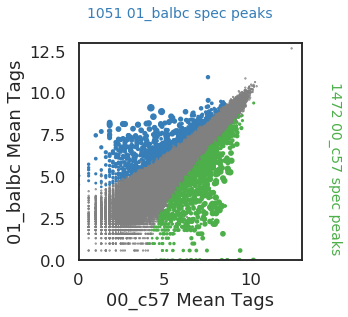

In [15]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N peaks down', np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)))
    print('N peaks up', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,14.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(14.5,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    # plt.close()

# Cluster differential enhancers:

### all enhancers

1144


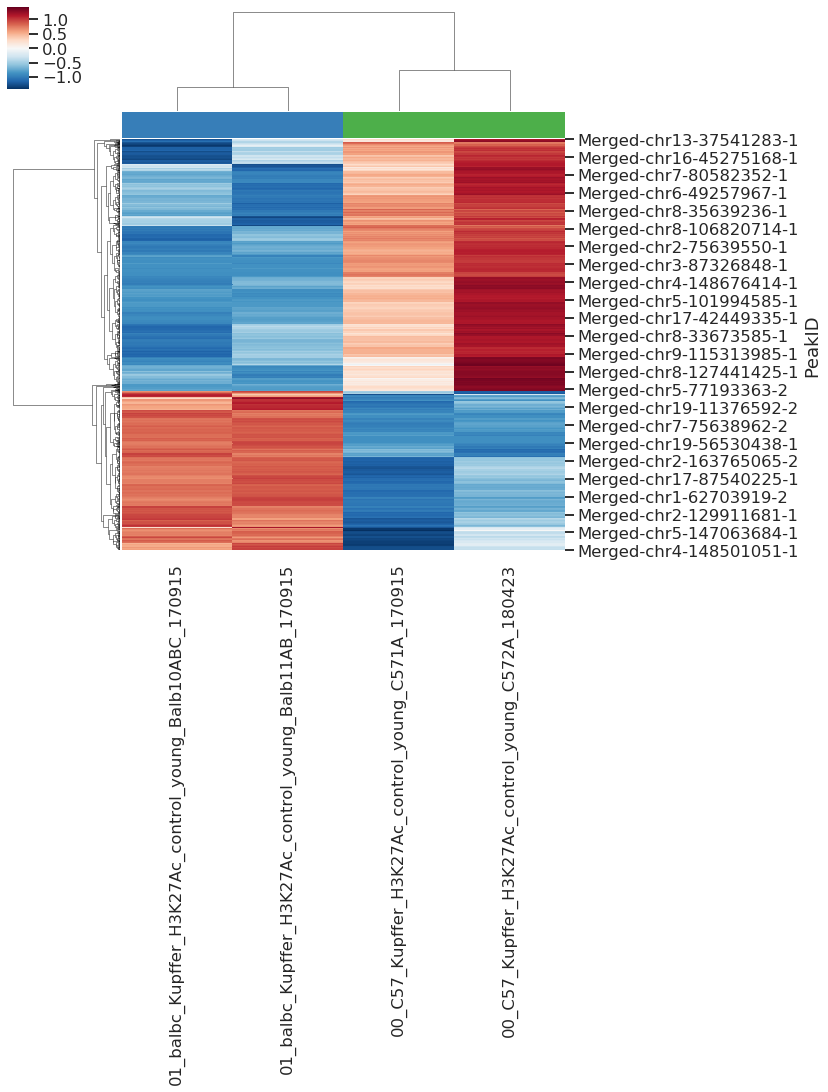

In [16]:
pval = 0.05
fc = 2

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)), :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#4daf4a', '#4daf4a',
                           '#377eb8', '#377eb8'])
plt.savefig('./figures/diff_peaks_clustermap.png', bbox_inches='tight')

### distal enhancers only

2069


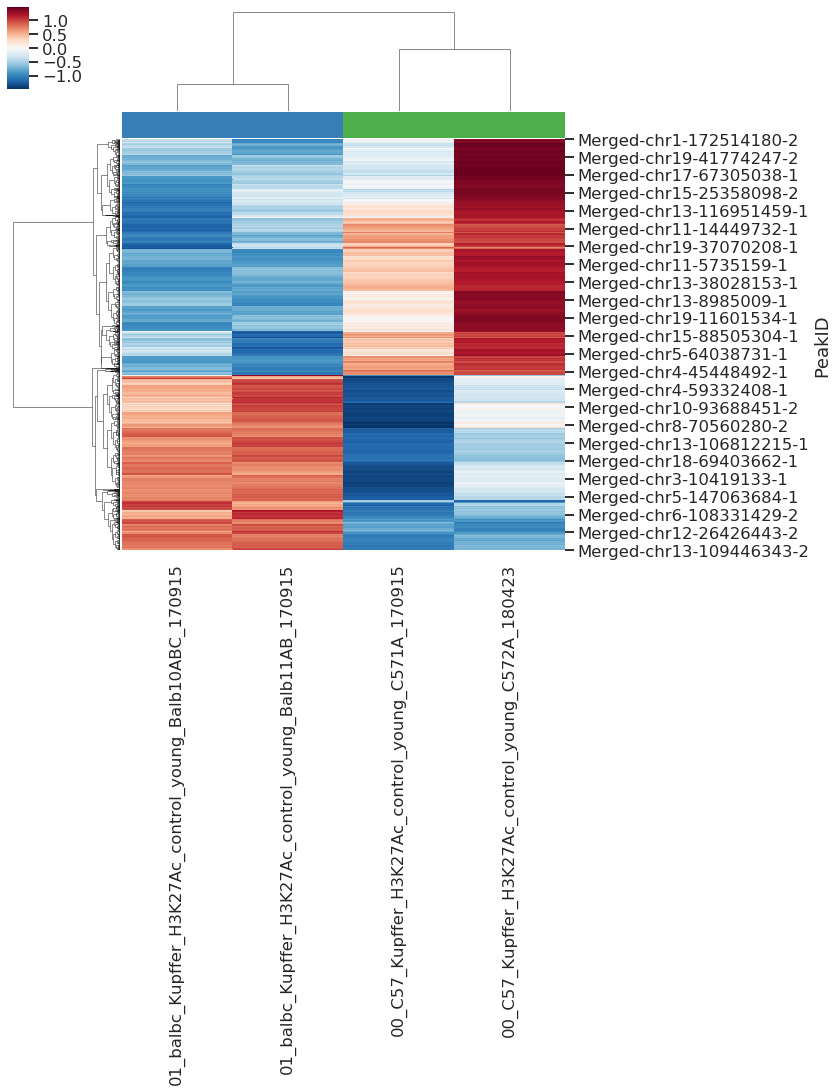

In [17]:
pval = 0.05
fc = 1

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) >= 3000))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#4daf4a', '#4daf4a',
                           '#377eb8', '#377eb8'])
plt.savefig('./figures/diff_peaks_distal_clustermap.png', bbox_inches='tight')

# Save differential peaks for analysis in GREAT

In [18]:
if not os.path.isdir('./great_analysis/'):
    os.mkdir('./great_analysis/')
    
if not os.path.isdir('./great_analysis/peak_files/'):
    os.mkdir('./great_analysis/peak_files/')
    
if not os.path.isdir('./great_analysis/bed_files/'):
    os.mkdir('./great_analysis/bed_files/')

In [19]:
# initialize dict and list of cell types
peak_lists = {}
bg_lists = {}
cells = ['00_c57',
         '01_balbc']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_c57 ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 1472 peaks
Intersection set at: 1472 peaks

Analyzing 01_balbc ...

0
For comp: 00_c57 vs. 01_balbc
Union set at: 1051 peaks
Intersection set at: 1051 peaks



### For annotated peaks we want to pull the peak locations from the original merged ATAC-seq file

In [28]:
atac_peaks = pd.read_csv('./merged_peaks/idr_peaks_merged.txt', sep='\t', index_col=0)

In [29]:
new_start = []
new_end = []
for index, row in atac_peaks.iterrows():
    center = row.start + int(np.floor((row.end - row.start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
atac_peaks_200bp = atac_peaks.iloc[:, :4].copy(deep=True)
atac_peaks_200bp['start'] = new_start
atac_peaks_200bp['end'] = new_end
atac_peaks_200bp.index.rename('PeakID', inplace=True)

if np.NaN get introduced into the matrix then it converts 'int' type columns to 'float' type columns, this is not ideal and interferes with downstream peak analysis so we create a dict to change the start and end columns back to integers just in case

In [32]:
convert_dict = {'start': int,
                'end': int}

In [33]:
for key in peak_lists.keys():
    # save cell specific promoters
    tmp = atac_peaks_200bp.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4]
    tmp = tmp.astype(convert_dict)
    # filter unknown chromosomes
    tmp = tmp.loc[~tmp.chr.str.contains('random'), :]
    tmp.to_csv('./great_analysis/peak_files/'+key+'_h3k27ac_act_peaks.txt',
               sep='\t')
        

Save full set of peaks for background

In [34]:
atac_peaks_200bp.iloc[:, :4].to_csv(
    './great_analysis/peak_files/pu1_all_peaks.txt',
    sep='\t')

Convert peaks to bed file

In [37]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

In [38]:
%%bash
for peakfile in ./great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [39]:
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')

In [40]:
!cp ./great_analysis/bed_files/* ./bed_files/

In [41]:
!ls ./bed_files/

00_balbc_intersection_poised_peaks.bed
00_balbc_union_poised_peaks.bed
00_c57_intersection_act_peaks.bed
00_c57_intersection_h3k27ac_act_peaks.bed
00_c57_intersectionh3k27ac_act_peaks.bed
00_c57_union_act_peaks.bed
00_c57_union_h3k27ac_act_peaks.bed
00_c57_unionh3k27ac_act_peaks.bed
01_balbc_intersection_act_peaks.bed
01_balbc_intersection_h3k27ac_act_peaks.bed
01_balbc_intersectionh3k27ac_act_peaks.bed
01_balbc_union_act_peaks.bed
01_balbc_union_h3k27ac_act_peaks.bed
01_balbc_unionh3k27ac_act_peaks.bed
01_c57_intersection_poised_peaks.bed
01_c57_union_poised_peaks.bed
all_peaks.bed
pu1_all_peaks.bed


### label for uploading to UCSC

In [42]:
with open('./label_bed.sh', 'w') as f:
    for i in glob.glob('./bed_files/*_h3k27ac_act_peaks.bed*'):

        strain = i.split('/')[-1].split('_')[1]
        settype = i.split('/')[-1].split('_')[2]
        group = "Control_Young"
        chip = 'PU1_H3K27Ac_Anno'

        # set track names for upload to ucsc genome browser
        lab = "'track name=\"%s_%s_%s_%s\" description=\"%s %s %s %s ChIP-seq DESeq2 \"'" % (strain, chip, group, settype, strain, group, chip, settype)
        lab_dist = "'track name=\"%s_%s_%s_%s_distal\" description=\"%s %s %s %s ChIP-seq DESeq2 \"'" % (strain, chip, group, settype, strain, group, chip, settype)

        # set labels - can't think of a more clever way to do this so we will just
        # use the simple if / else statement to switch labels depending on our 
        # peak set being distal or all
        
        if 'distal' in i:
            l = lab_dist
        else:
            l = lab
        
        label_track = ['echo', l, '|', 'cat', '-',
                       i,
                       '> temp && mv temp',
                       i, '\n']
    
        f.write(' '.join(label_track))
        
    f.close()

label all peaks post-hoc

In [43]:
# %%bash

# echo 'track name="kupffer_control_young_atac_merged" description="Kupffer Young Control ATAC All Strains"' \
# | cat - ./bed_files/all_peaks.bed \
# > temp && mv temp ./bed_files/all_peaks.bed

# Check bed files and peaks in browser

In [50]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [51]:
viz_cols = ['Gene Name', 'Gene Description', 'location', 'Annotation',
            '00_c57 vs. 01_balbc Log2 Fold Change','00_c57 vs. 01_balbc adj. p-value']

In [52]:
diff_peak_viz = diff_peak.loc[:, viz_cols]

In [54]:
diff_peak_viz.sort_values(
    '00_c57 vs. 01_balbc adj. p-value', ascending=True).head(40)

,Gene Name,Gene Description,location,Annotation,00_c57 vs. 01_balbc Log2 Fold Change,00_c57 vs. 01_balbc adj. p-value
PeakID,,,,,,
Merged-chr11-3157651-1,Pisd-ps1,"phosphatidylserine decarboxylase, pseudogene 1",chr11:3157151-3158151,"intron (NM_030207, intron 11 of 32)",4.919846,3.598728e-37
Merged-chr17-71265855-1,Emilin2,elastin microfibril interfacer 2,chr17:71265355-71266355,"intron (NM_001357338, intron 4 of 7)",4.034952,2.662172e-32
Merged-chr2-163764576-1,Ada,adenosine deaminase,chr2:163764076-163765076,Intergenic,4.233201,2.977181e-27
Merged-chr17-33980617-1,AA388235,expressed sequence AA388235,chr17:33980117-33981117,promoter-TSS (NR_033305),-5.254468,3.944672e-27
Merged-chr19-37048725-1,Btaf1,B-TFIID TATA-box binding protein associated fa...,chr19:37048225-37049225,"intron (NM_198300, intron 9 of 10)",-3.603600,1.057744e-26
Merged-chr17-27038478-1,Ggnbp1,gametogenetin binding protein 1,chr17:27037978-27038978,Intergenic,-5.489164,1.432159e-26
Merged-chr17-36121500-1,H2-T10,"histocompatibility 2, T region locus 10",chr17:36121000-36122000,promoter-TSS (NR_046286),-3.529598,1.432159e-26
Merged-chr7-16207750-1,Dhx34,DEAH (Asp-Glu-Ala-His) box polypeptide 34,chr7:16207250-16208250,"intron (NM_027883, intron 7 of 16)",-3.287454,5.095315e-25
Merged-chr17-27037820-1,Ggnbp1,gametogenetin binding protein 1,chr17:27037320-27038320,Intergenic,-5.330975,2.372099e-24
